In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision as TV

In [7]:
mnist_data = TV.datasets.MNIST(
    'MNIST/',
    train=True,
    transform=None,
    target_transform=None,
    download=True)
mnist_test = TV.datasets.MNIST(
    'MNIST/',
    train=False,
    transform=None,
    target_transform=None,
    download=True)

In [13]:
# adds random points to image
def add_spots(x, m=20, std=5, val=1):
    mask = torch.zeros(x.shape)
    N = int(m + std * np.abs(np.random.randn()))
    ids = np.random.randint(np.prod(x.shape), size=N)
    mask.view(-1)[ids] = val
    return torch.clamp(x + mask, 0, 1)

def prepare_image(xt, maxtrans=6, rot=5, noise=10):
    out = torch.zeros(xt.shape)
    for i in range(xt.shape[0]):
        img = xt[i].unsqueeze(dim=0)
        img = TV.transforms.functional.to_pil_image(img)
        rand_rot = np.random.randint(-1 * rot, rot) if rot > 0 else 0
        xtrans, ytrans = np.random.randint(-maxtrans, maxtrans, 2)
        img = TV.transforms.functional.affine(img, rand_rot, (xtrans, ytrans), 1, 0)
        img = TV.transforms.functional.to_tensor(img).squeeze()
        if noise > 0:
            img = add_spots(img, m=noise)
        maxval = img.view(-1).max()
        if maxval > 0:
            img = img.float() / maxval
        else:
            img = img.float()
        out[i] = img
    return out

In [5]:
class RelationalModule(torch.nn.Module):
    def __init__(self):
        super(RelationalModule, self).__init__()
        self.ch_in = 1
        # number of channels for each convolutional layer
        self.conv1_ch = 16
        self.conv2_ch = 20
        self.conv3_ch = 24
        self.conv4_ch = 30
        # height and width of the input image
        self.H = 28
        self.W = 28
        # dimension of the nodes after passing through the
        # relational module
        self.node_size = 36
        self.lin_hid = 100
        self.out_dim = 10
        self.sp_coord_dim = 2
        # the number of objects or nodes, which is just the number
        # of pixels after passing through the convolutions
        self.N = int(16 ** 2)

        self.conv1 = nn.Conv2d(self.ch_in, self.conv1_ch, kernel_size=(4, 4))
        self.conv2 = nn.Conv2d(self.conv1_ch, self.conv2_ch, kernel_size=(4, 4))
        self.conv3 = nn.Conv2d(self.conv2_ch, self.conv3_ch, kernel_size=(4, 4))
        self.conv4 = nn.Conv2d(self.conv3_ch, self.conv4_ch, kernel_size=(4, 4))

        # the dimensionality of each node vector is the number of channels in the
        # last convolution plus 2 spatial dimensions
        self.proj_shape = (self.conv4_ch + self.sp_coord_dim, self.node_size)
        self.k_proj = nn.Linear(*self.proj_shape)
        self.q_proj = nn.Linear(*self.proj_shape)
        self.v_proj = nn.Linear(*self.proj_shape)

        self.norm_shape = (self.N, self.node_size)
        self.k_norm = nn.LayerNorm(self.norm_shape, elementwise_affine=True)
        self.q_norm = nn.LayerNorm(self.norm_shape, elementwise_affine=True)
        self.v_norm = nn.LayerNorm(self.norm_shape, elementwise_affine=True)

        self.linear1 = nn.Linear(self.node_size, self.node_size)
        self.norm1 = nn.LayerNorm([self.N, self.node_size], elementwise_affine=True)
        self.linear2 = nn.Linear(self.node_size, self.out_dim)

    def forward(self, x):
        N, Cin, H, W = x.shape
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = x.squeeze()
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = torch.relu(x)

        _, _, cH, cW = x.shape
        xcoords = torch.arange(cW).repeat(cH, 1).float() / cW
        ycoords = torch.arange(cH).repeat(cW, 1).transpose(1, 0).float() / cW
        spatial_coords = torch.stack([xcoords, ycoords], dim=0)
        spatial_coords = spatial_coords.unsqueeze(dim=0)
        spatial_coords = spatial_coords.repeat(N, 1, 1, 1)
        x = torch.cat([x, spatial_coords], dim=1)
        x = x.permute(0, 2, 3, 1)
        x = x.flatten(1, 2)

        K = self.k_proj(x)
        K = self.k_norm(K)

        Q = self.q_proj(x)
        Q = self.q_norm(Q)

        V = self.v_proj(x)
        V = self.v_norm(V)

        A = torch.einsum('bfe,bge->bfg', Q, K)
        A = A / np.sqrt(self.node_size)
        A = torch.nn.functional.softmax(A, dim=2)
        with torch.no_grad():
            self.att_map = A.clone()
        E = torch.einsum('bfc,bcd->bfd', A, V)
        E = self.linear1(E)
        E = torch.relu(E)
        E = E.max(dim=1)[0]
        y = self.linear2(E)
        y = torch.nn.functional.log_softmax(y, dim=1)
        return y

In [14]:
from IPython.display import clear_output

agent = RelationalModule()
epochs = 1000
batch_size = 300
lr = 1e-3
opt = torch.optim.Adam(params=agent.parameters(), lr=lr)
lossfn = nn.NLLLoss()
losses = []
accs = []

for i in range(epochs):
    opt.zero_grad()
    batch_ids = np.random.randint(0, 60000, size=batch_size)
    xt = mnist_data.train_data[batch_ids].detach()
    xt = prepare_image(xt, rot=30).unsqueeze(dim=1)
    yt = mnist_data.train_labels[batch_ids].detach()
    pred = agent(xt)
    pred_labels = torch.argmax(pred, dim=1)
    acc_ = 100.0 * (pred_labels == yt).sum() / batch_size
    correct = torch.zeros(batch_size, 10)
    rows = torch.arange(batch_size).long()
    correct[[rows, yt.detach().long()]] = 1.
    loss = lossfn(pred, yt)
    loss.backward()
    opt.step()

    losses.append(loss)
    accs.append(acc_)

    clear_output()
    print('%d / %d: accuracy: %d, loss: %d' % (i + 1, epochs, acc_, loss))



1000 / 1000: accuracy: 93, loss: 0


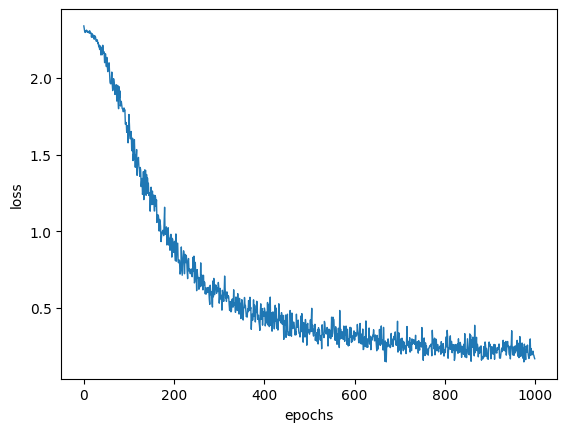

In [20]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot([l.item() for l in losses], linewidth=1)

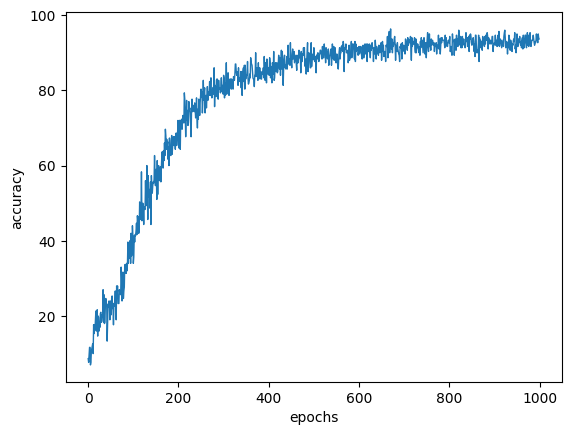

In [19]:
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot([a.item() for a in accs], linewidth=1)

In [38]:
def test_acc(model, batch_size=500):
    acc = 0
    batch_ids = np.random.randint(0, 10000, size=batch_size)
    xt = mnist_test.test_data[batch_ids].detach()
    xt = prepare_image(xt, maxtrans=6, rot=30, noise=10).unsqueeze(dim=1)
    yt = mnist_test.test_labels[batch_ids].detach()
    preds = model(xt)
    pred_ind = torch.argmax(preds.detach(), dim=1)
    acc = (pred_ind == yt).sum().float() / batch_size
    return acc, xt, yt

acc2, xt2, yt2 = test_acc(agent)
print('test accuracy: %f' % (acc2.item()))

test accuracy: 0.938000
